In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy.linalg import orth
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.decomposition import PCA
from terminaltables import AsciiTable as Table
from tqdm import tqdm_notebook as tqdm

In [2]:
def estimate_optimal_ncomponents(mat):
    pca = PCA()
    pca.fit(mat)
    opt = []
    total_var = 0
    nc = 0
    for var in pca.explained_variance_ratio_:
        total_var += var
        nc += 1
        if total_var >= 0.99:
            opt.append(nc)
            break
        elif total_var >= 0.95:
            opt.append(nc)
    return opt[0], opt[-1], len(pca.explained_variance_ratio_)

def pca_transform(mat):
    _, n, _ = estimate_optimal_ncomponents(mat)
    pca = PCA(n_components=n)
    return pca.fit_transform(mat)

def cosine_sim(u, v):
    return 1-cosine(u, v)

In [5]:
data = ['mnist', 'fmnist', 'cifar']
lrs = [1e-1, 1e-2, 1e-3]
clfs = ['resnet18', 'fcn', 
#         'svm'
       ]

files = {}
for d in data:
    for lr in lrs:
        for clf in clfs:
            if clf == 'svm' and d=='cifar':
                lr *= 1e-3
            elif clf == 'svm':
                    lr *= 1e-2
            files[
                '../ckpts/{}_centralized/history/'
                'clf_{}_paradigm_sgd_lr_{}_decay_'
                '1e-05_batch_60000.pkl'.format(d, clf, lr)] = '{}/{}/{}'.format(d,clf,lr)

```python
for file in files:
    print("+"*80)
    print(file)
    print("+"*80)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    best_acc_i = np.argmax(acc_test)
    best_acc = acc_test[best_acc_i]
    best_loss_i = np.argmin(loss_test)
    best_loss = loss_test[best_loss_i]
    grads = grads[:epochs]
    table = [['shape', 'stacked', 'max(1.00)', 'opt(0.95)', 'opt(0.99)']]
    tot_opt_95 = 0
    tot_opt_99 = 0
    tot_epochs = 0
    for layer_num in range(len(grads[0])):
        accum = []
        for epoch_num in range(len(grads)):
            g = grads[epoch_num][layer_num]
            shape = g.shape
            accum.append(g.reshape(1, -1).cpu().numpy())
        stack_g = np.vstack(accum)
        o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
        tot_opt_95 += o_95
        tot_opt_99 += o_99
        tot_epochs += 1
        table.append([shape, stack_g.T.shape, o_epochs, o_95, o_99])
        
    table.append(['average', 
                  '{:.4f}({})'.format(best_acc, best_acc_i), 
                  '{:.4f}({})'.format(best_loss, best_loss_i),
                  '{:.4f}'.format(tot_opt_95/tot_epochs), 
                  '{:.4f}'.format(tot_opt_99/tot_epochs)])
    table = Table(table)
    table.justify_columns[1] = 'right'
    table.justify_columns[2] = 'right'
    table.justify_columns[3] = 'right'
    table.inner_footing_row_border = True
    print(table.table)
    break
```

mnist/resnet18/0.1
mnist/fcn/0.1
mnist/resnet18/0.01
mnist/fcn/0.01
mnist/resnet18/0.001
mnist/fcn/0.001
fmnist/resnet18/0.1
fmnist/fcn/0.1
fmnist/resnet18/0.01
fmnist/fcn/0.01
fmnist/resnet18/0.001
fmnist/fcn/0.001
cifar/resnet18/0.1
cifar/fcn/0.1
cifar/resnet18/0.01
cifar/fcn/0.01
cifar/resnet18/0.001
cifar/fcn/0.001


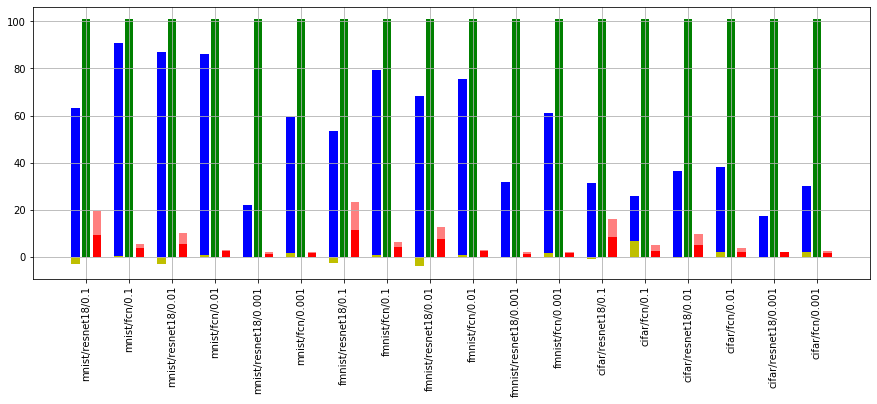

In [6]:
epochs = 101
idx = 1
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
tick_names = []
ticks = []
for file, tick_name in files.items():
    print(tick_name)
    ticks.append(idx)
    tick_names.append(tick_name)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    best_acc_i = np.argmax(acc_test)
    best_acc = acc_test[best_acc_i]
    best_loss_i = np.argmin(loss_test)
    best_loss = loss_test[best_loss_i]
    grads = grads[:epochs]
    table = [['shape', 'stacked', 'max(1.00)', 'opt(0.95)', 'opt(0.99)']]
    tot_opt_95 = 0
    tot_opt_99 = 0
    tot_epochs = 0
    for layer_num in range(len(grads[0])):
        accum = []
        for epoch_num in range(len(grads)):
            g = grads[epoch_num][layer_num]
            shape = g.shape
            accum.append(g.reshape(1, -1).cpu().numpy())
        stack_g = np.vstack(accum)
        o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
        tot_opt_95 += o_95
        tot_opt_99 += o_99
        tot_epochs += 1
        table.append([shape, stack_g.T.shape, o_epochs, o_95, o_99])
    table.append(['average', 
                  '{:.4f}({})'.format(best_acc, best_acc_i), 
                  '{:.4f}({})'.format(best_loss, best_loss_i),
                  '{:.4f}'.format(tot_opt_95/tot_epochs), 
                  '{:.4f}'.format(tot_opt_99/tot_epochs)])
    plt.bar(idx-0.25, best_acc*100, width = 0.2, color='b')
    plt.bar(idx-0.25, best_loss, width=0.2, color='y')
    plt.bar(idx, len(grads), width=0.2, color='g')
    plt.bar(idx+0.25, tot_opt_95/tot_epochs, width=0.2, color='r')
    plt.bar(idx+0.25, tot_opt_99/tot_epochs, width=0.2, color='r', alpha=0.5)
    idx += 1
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_names, rotation='vertical')
ax1.grid()
plt.show()

mnist/resnet18/0.1
mnist/fcn/0.1
mnist/resnet18/0.01
mnist/fcn/0.01
mnist/resnet18/0.001
mnist/fcn/0.001
fmnist/resnet18/0.1
fmnist/fcn/0.1
fmnist/resnet18/0.01
fmnist/fcn/0.01
fmnist/resnet18/0.001
fmnist/fcn/0.001
cifar/resnet18/0.1
cifar/fcn/0.1
cifar/resnet18/0.01
cifar/fcn/0.01
cifar/resnet18/0.001
cifar/fcn/0.001


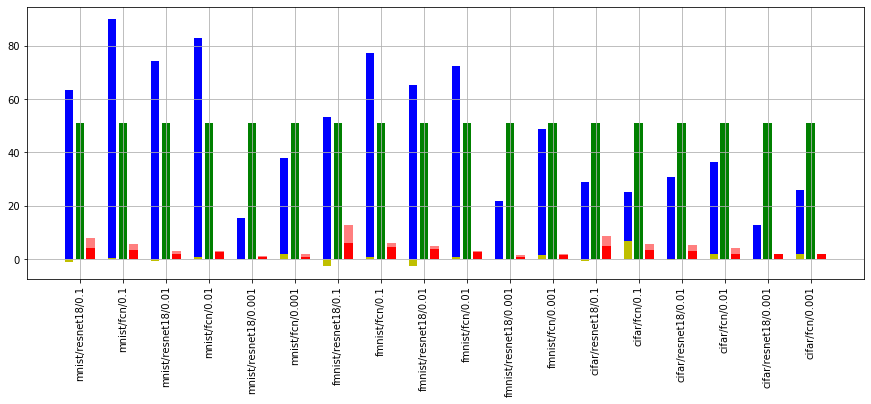

In [7]:
epochs = 51
idx = 1
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
tick_names = []
ticks = []
for file, tick_name in files.items():
    print(tick_name)
    ticks.append(idx)
    tick_names.append(tick_name)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    grads = grads[:epochs]
    acc_test = acc_test[:epochs]
    loss_test = loss_test[:epochs]
    best_acc_i = np.argmax(acc_test)
    best_acc = acc_test[best_acc_i]
    best_loss_i = np.argmin(loss_test)
    best_loss = loss_test[best_loss_i]
    grads = grads[:epochs]
    table = [['shape', 'stacked', 'max(1.00)', 'opt(0.95)', 'opt(0.99)']]
    tot_opt_95 = 0
    tot_opt_99 = 0
    tot_epochs = 0
    for layer_num in range(len(grads[0])):
        accum = []
        for epoch_num in range(len(grads)):
            g = grads[epoch_num][layer_num]
            shape = g.shape
            accum.append(g.reshape(1, -1).cpu().numpy())
        stack_g = np.vstack(accum)
        o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
        tot_opt_95 += o_95
        tot_opt_99 += o_99
        tot_epochs += 1
        table.append([shape, stack_g.T.shape, o_epochs, o_95, o_99])
    table.append(['average', 
                  '{:.4f}({})'.format(best_acc, best_acc_i), 
                  '{:.4f}({})'.format(best_loss, best_loss_i),
                  '{:.4f}'.format(tot_opt_95/tot_epochs), 
                  '{:.4f}'.format(tot_opt_99/tot_epochs)])
    plt.bar(idx-0.25, best_acc*100, width = 0.2, color='b')
    plt.bar(idx-0.25, best_loss, width=0.2, color='y')
    plt.bar(idx, len(grads), width=0.2, color='g')
    plt.bar(idx+0.25, tot_opt_95/tot_epochs, width=0.2, color='r')
    plt.bar(idx+0.25, tot_opt_99/tot_epochs, width=0.2, color='r', alpha=0.5)
    idx += 1
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_names, rotation='vertical')
ax1.grid()
plt.show()

../ckpts/mnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


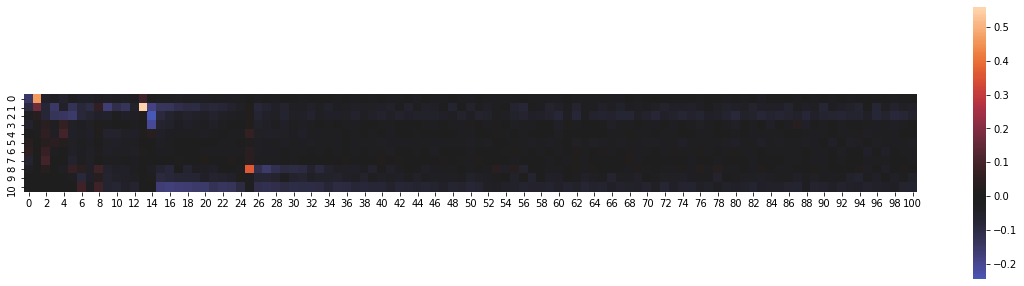

In [94]:
epochs = 101
for file in files:
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(111)
    print(file)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    grads = grads[:epochs]
    corr_mat = np.zeros((epochs, epochs))
    num_layers = 0
    components = []
    for layer_num in tqdm(range(len(grads[0])), leave=False):
        num_layers += 1
        accum = []
        for epoch_num in range(len(grads)):
            g = grads[epoch_num][layer_num]
            shape = g.shape
            accum.append(g.reshape(1, -1).cpu().numpy())
        stack_g = np.vstack(accum).T
        pca_g = pca_transform(stack_g)
        components.append(pca_g.shape[1])
        pca_g = normalize(pca_g, axis=0)
#         stack_g, _ = np.linalg.qr(stack_g)
        stack_g = normalize(stack_g, axis=0)
        corr = np.matmul(pca_g.T, stack_g)
        corr_mat[:corr.shape[0], :corr.shape[1]] += corr 
    sns.heatmap(corr_mat[:sum(components)//len(components)]/num_layers, center=0.0, square=True)
    plt.show()
    break

../ckpts/mnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


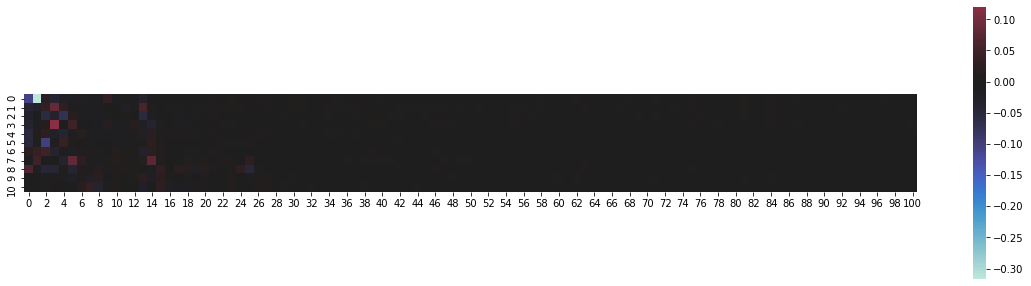

../ckpts/mnist_centralized/history/clf_fcn_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


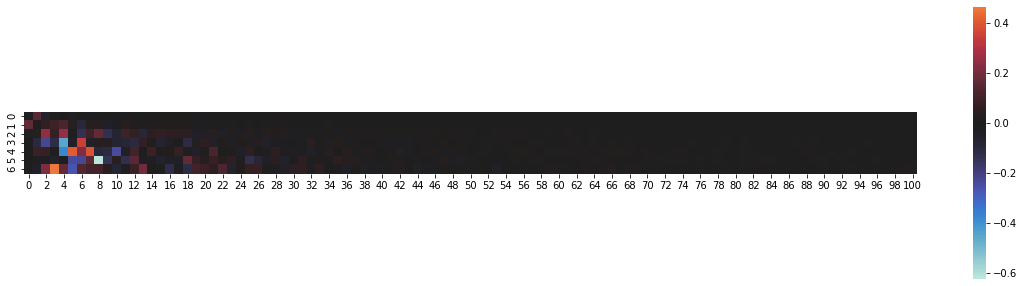

../ckpts/mnist_centralized/history/clf_svm_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


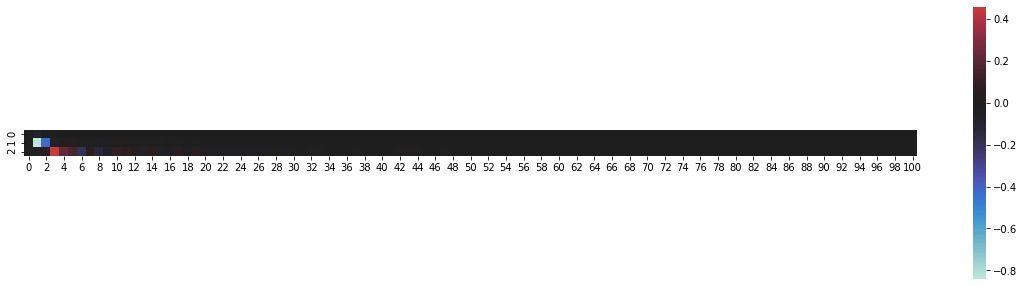

../ckpts/mnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.01_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


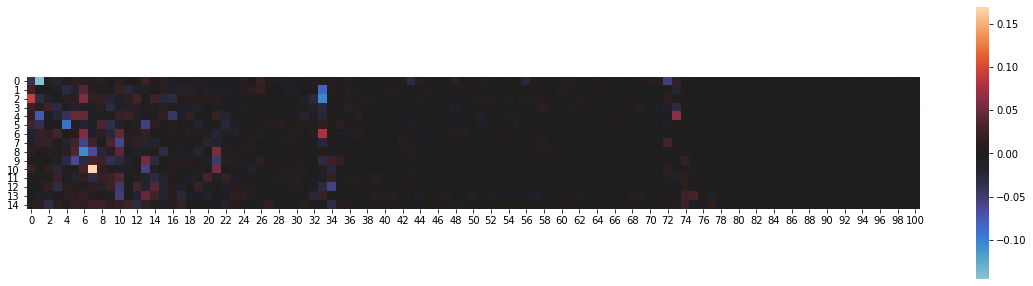

../ckpts/mnist_centralized/history/clf_fcn_paradigm_sgd_lr_0.01_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


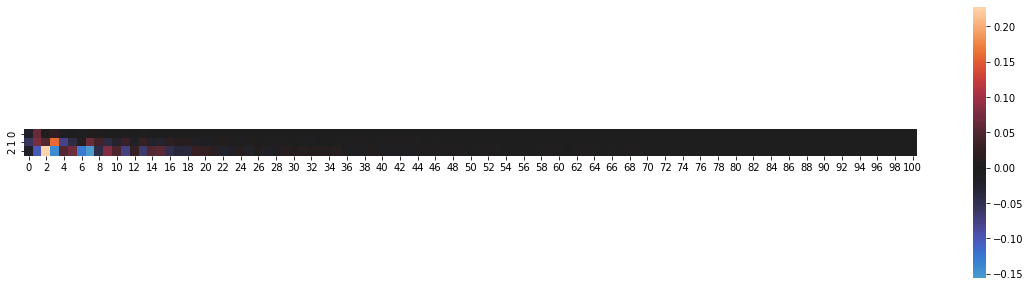

../ckpts/mnist_centralized/history/clf_svm_paradigm_sgd_lr_0.0001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


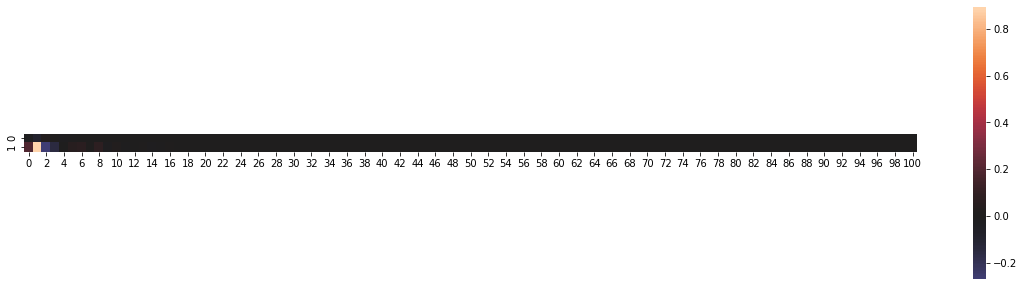

../ckpts/mnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


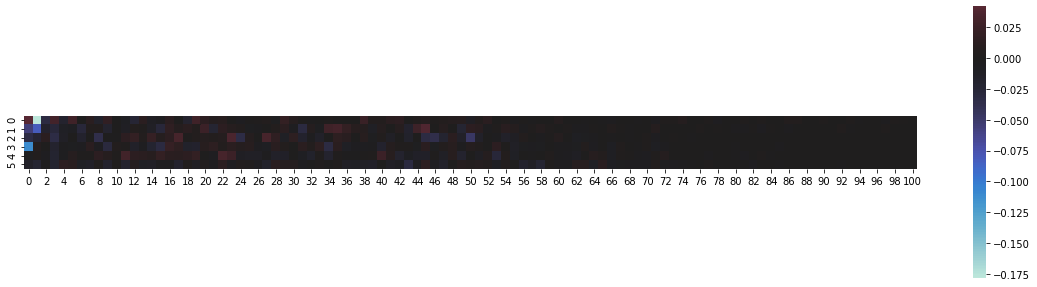

../ckpts/mnist_centralized/history/clf_fcn_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


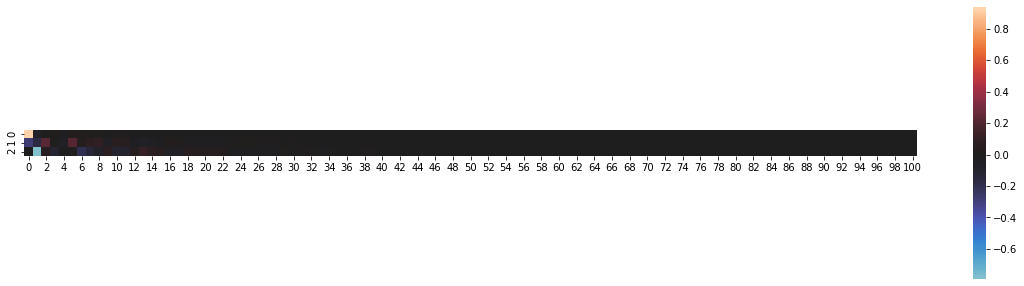

../ckpts/mnist_centralized/history/clf_svm_paradigm_sgd_lr_1e-05_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


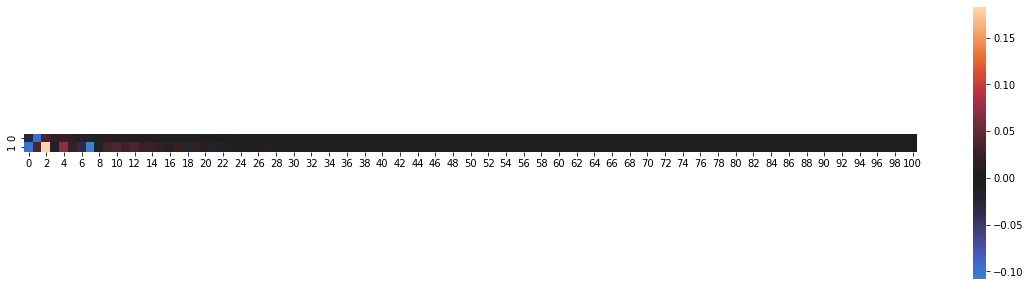

../ckpts/fmnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


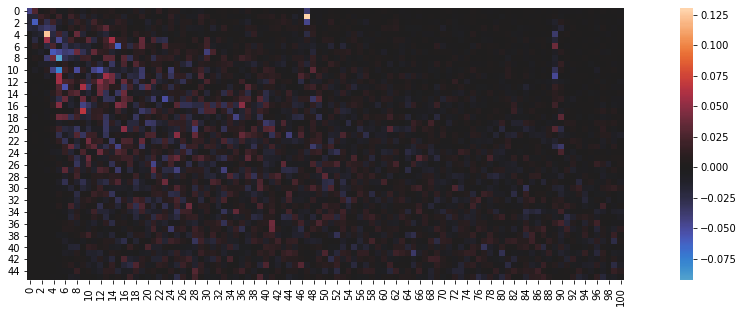

../ckpts/fmnist_centralized/history/clf_fcn_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


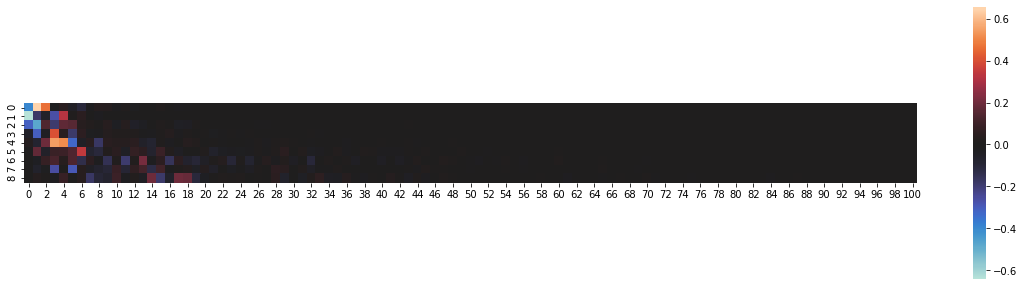

../ckpts/fmnist_centralized/history/clf_svm_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


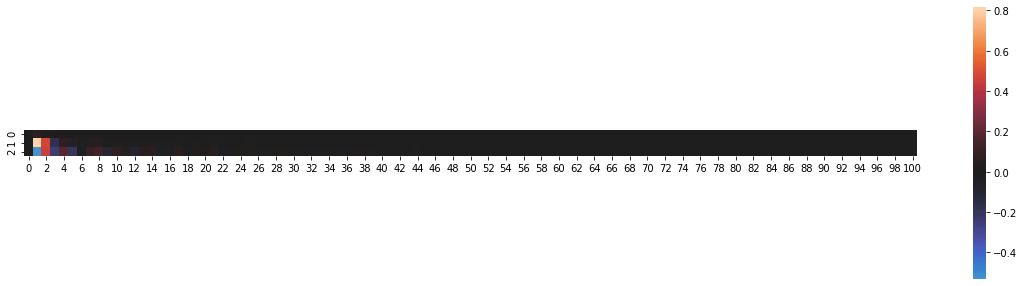

../ckpts/fmnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.01_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


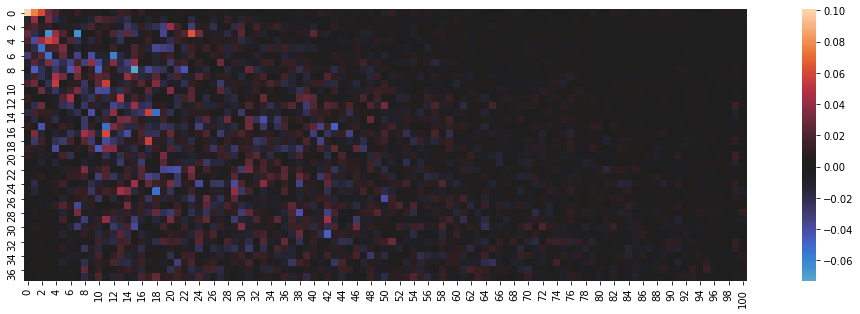

../ckpts/fmnist_centralized/history/clf_fcn_paradigm_sgd_lr_0.01_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


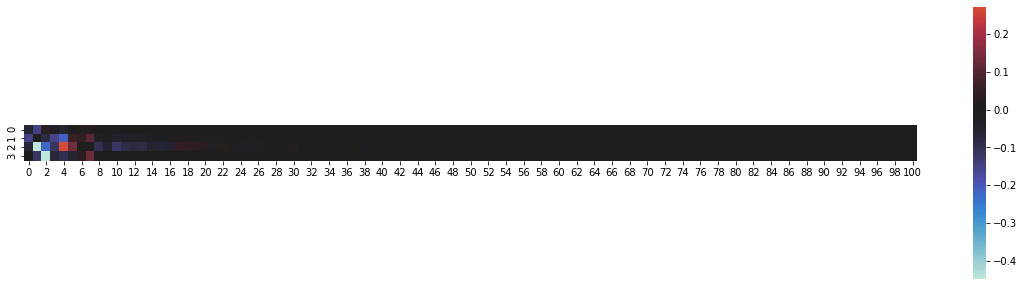

../ckpts/fmnist_centralized/history/clf_svm_paradigm_sgd_lr_0.0001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


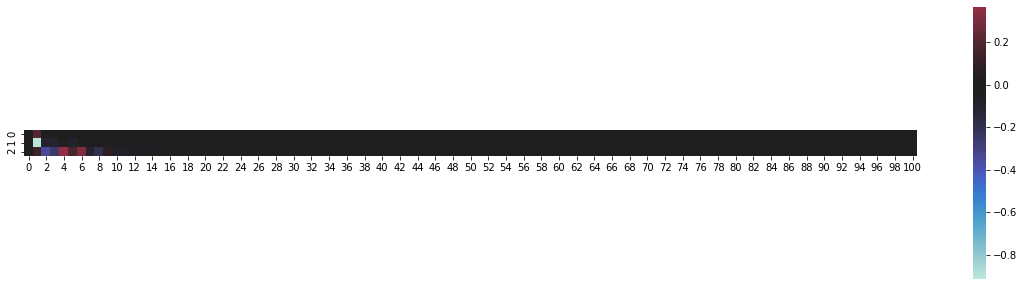

../ckpts/fmnist_centralized/history/clf_resnet18_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


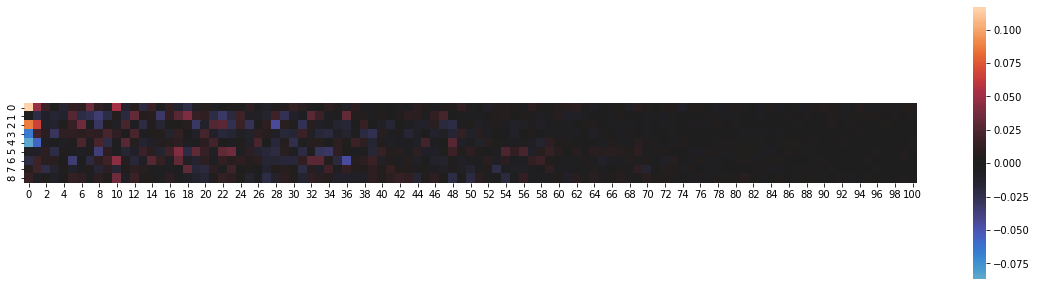

../ckpts/fmnist_centralized/history/clf_fcn_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


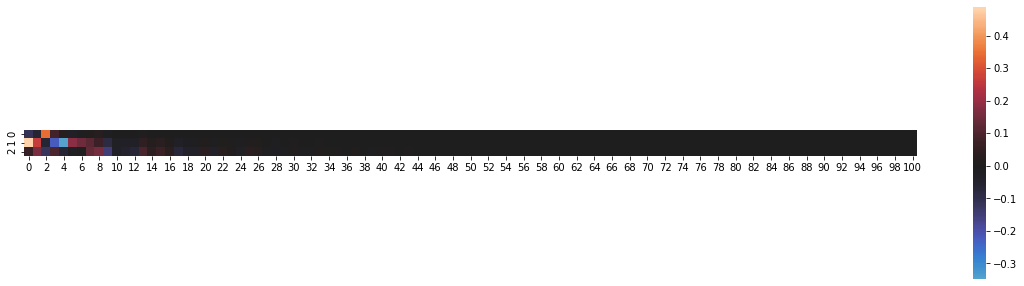

../ckpts/fmnist_centralized/history/clf_svm_paradigm_sgd_lr_1e-05_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


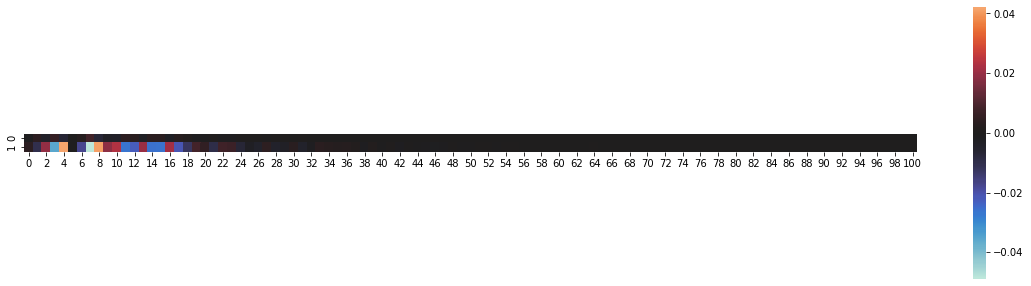

../ckpts/cifar_centralized/history/clf_resnet18_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


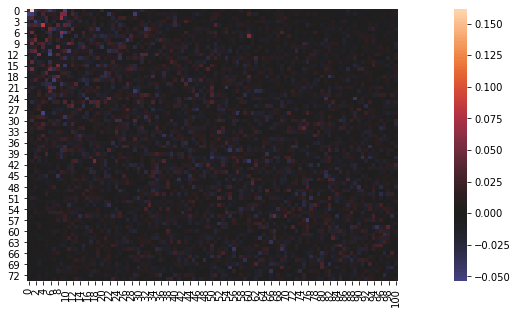

../ckpts/cifar_centralized/history/clf_fcn_paradigm_sgd_lr_0.1_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


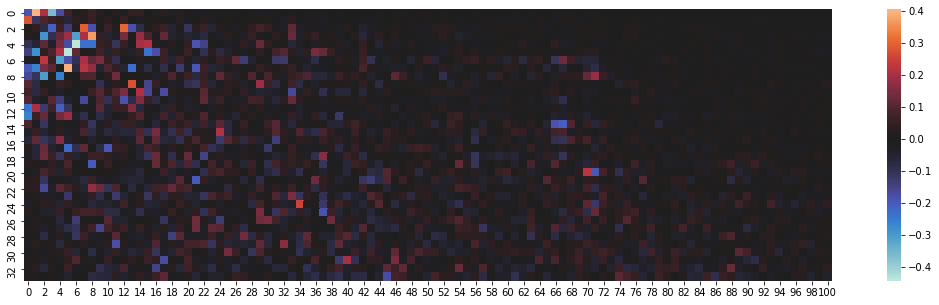

../ckpts/cifar_centralized/history/clf_svm_paradigm_sgd_lr_0.0001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


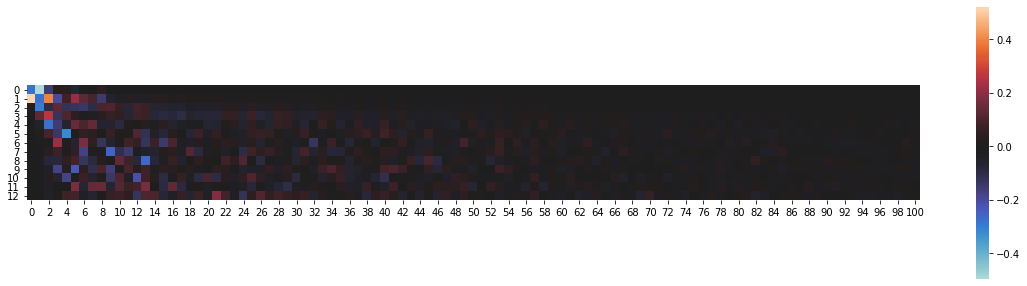

../ckpts/cifar_centralized/history/clf_resnet18_paradigm_sgd_lr_0.01_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


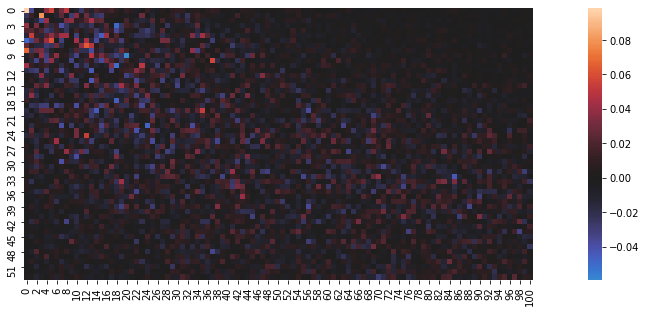

../ckpts/cifar_centralized/history/clf_fcn_paradigm_sgd_lr_0.01_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


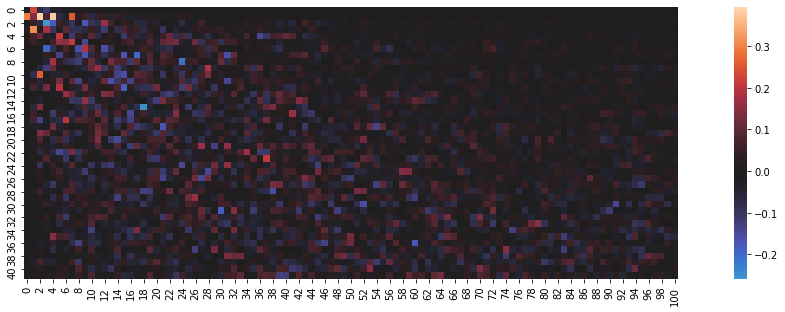

../ckpts/cifar_centralized/history/clf_svm_paradigm_sgd_lr_1e-05_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


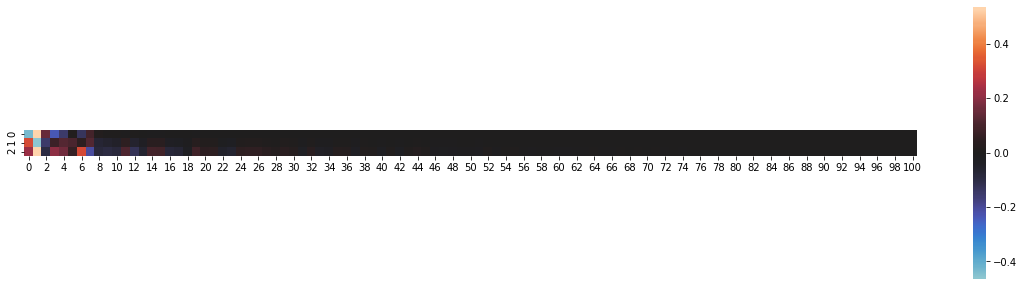

../ckpts/cifar_centralized/history/clf_resnet18_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


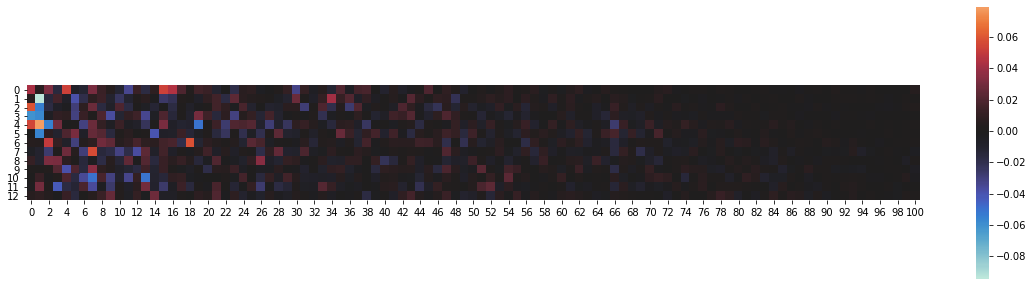

../ckpts/cifar_centralized/history/clf_fcn_paradigm_sgd_lr_0.001_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


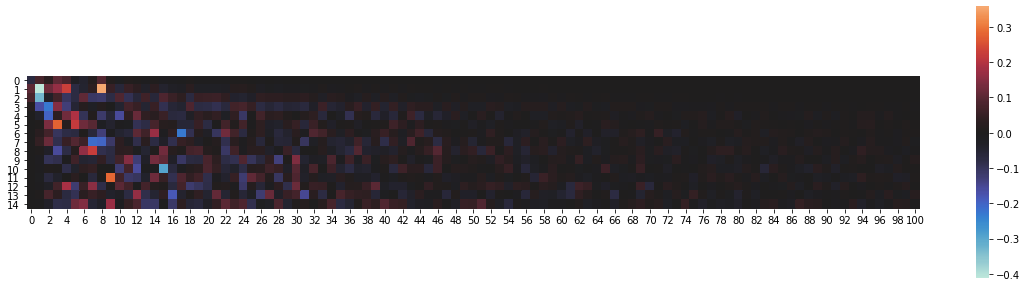

../ckpts/cifar_centralized/history/clf_svm_paradigm_sgd_lr_1e-06_decay_1e-05_batch_4096.pkl


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


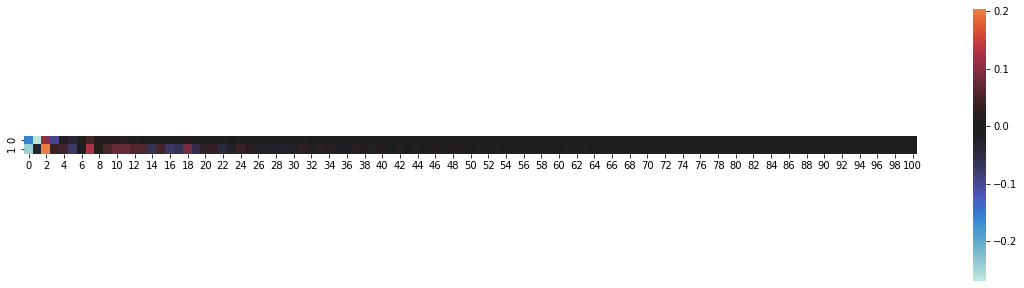

In [93]:
epochs = 101
for file in files:
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(111)
    print(file)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    grads = grads[:epochs]
    corr_mat = np.zeros((epochs, epochs))
    num_layers = 0
    components = []
    for layer_num in tqdm(range(len(grads[0])), leave=False):
        num_layers += 1
        accum = []
        for epoch_num in range(len(grads)):
            g = grads[epoch_num][layer_num]
            shape = g.shape
            accum.append(g.reshape(1, -1).cpu().numpy())
        stack_g = np.vstack(accum).T
        pca_g = pca_transform(stack_g)
        components.append(pca_g.shape[1])
        pca_g = normalize(pca_g, axis=0)
#         stack_g, _ = np.linalg.qr(stack_g)
        stack_g = normalize(stack_g, axis=0)
        corr = np.matmul(pca_g.T, stack_g)
        corr_mat[:corr.shape[0], :corr.shape[1]] += corr 
    sns.heatmap(corr_mat[:sum(components)//len(components)]/num_layers, center=0.0, square=True)
    plt.show()
    break